## Imports

In [1]:
from src.analysis.basic_graph_analyzer import BasicGraphAnalyzer
from src.analysis.centrality_analyzer import CentralityAnalyzer
from src.analysis.scale_free_analyzer import ScaleFreeAnalyzer
from src.acquisition.models.database_manager import DatabaseManager
from src.acquisition.models.db.database import db
from src.acquisition.models.db.database import initialize_db
import matplotlib.pyplot as plt
import numpy as np
import powerlaw
from scipy import special


## Initialize Database & helper methods

In [2]:
graph_names = ['Amiga CD32 games', 'Machine learning', 'Artificial intelligence', 'Game Boy games']

name  = graph_names[0]
db_name = 'wikipedia.db'
initialize_db(db_name)  
db_manager = DatabaseManager(db)

def get_unique_contributors_list_from_graph_name(graph_name):
    main_category_id = db_manager.get_main_category_by_name(graph_name)
    unique_contributors_per_article = db_manager.get_distinct_contributors_per_page(main_category_id)
    return list(unique_contributors_per_article.values())

def calculate_poisson_degree_distribution(degrees, logarithmic_bins):
        lamda = np.mean(degrees)
        x = logarithmic_bins
        y = np.exp(-lamda) * np.power(lamda, x) / special.factorial(x)
        x = x[y > 0]
        y = y[y > 0]
        return x, y

def calculate_exponential_degree_distribution(degrees, logarithmic_bins):
        lamda = np.mean(degrees)
        beta = 1 / lamda
        x = logarithmic_bins
        y = beta * np.exp(-beta * x)
        # remove entries with 0 probability
        x = x[y > 0]
        y = y[y > 0]
        return x, y

Database initialized: wikipedia.db


## Plot bar histograms

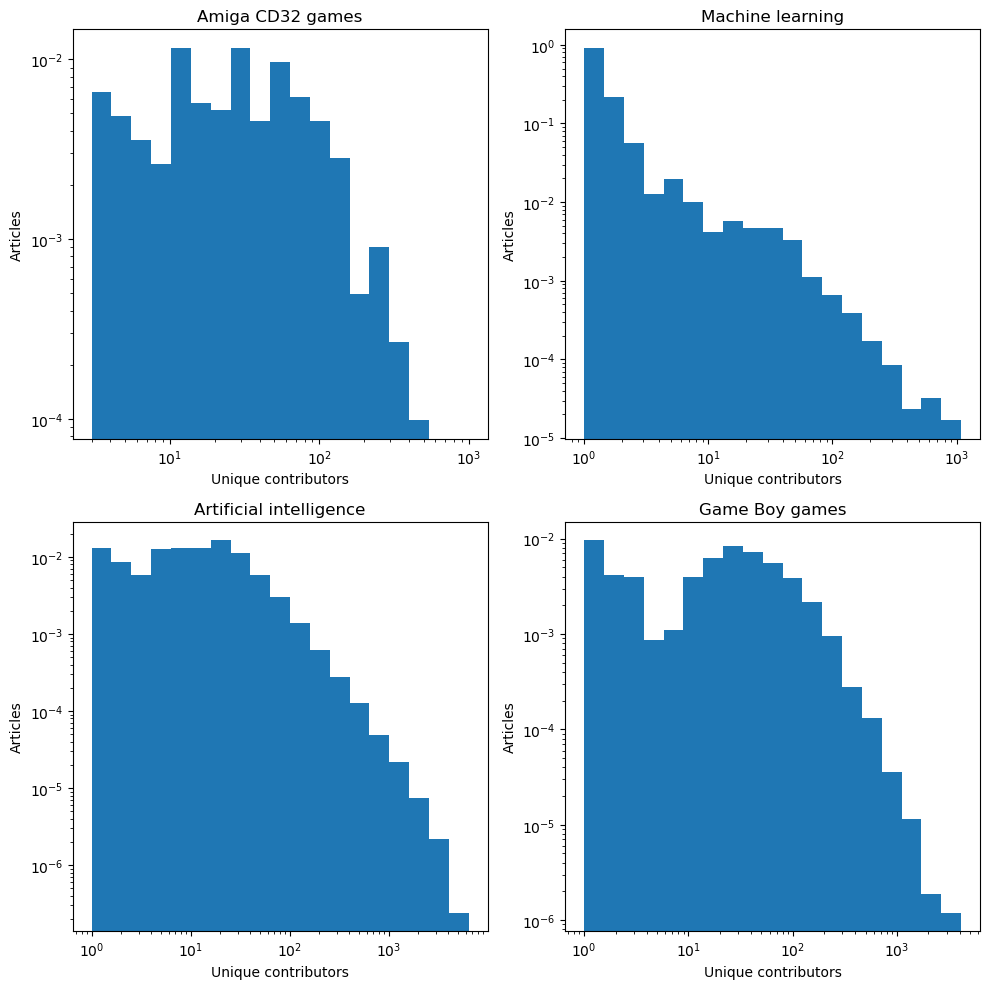

In [3]:
fig, axs = plt.subplots(2,2, figsize=(10,10))

for i, name in enumerate(graph_names):
    unique_contributors = get_unique_contributors_list_from_graph_name(name)
    logarithmic_bins = np.logspace(np.log10(min(unique_contributors)), np.log10(max(unique_contributors)), num=20)
    axs[i//2, i%2].hist(unique_contributors, bins=logarithmic_bins, density=True)
    axs[i//2, i%2].set_xscale('log')
    axs[i//2, i%2].set_yscale('log')
    axs[i//2, i%2].set_xlabel('Unique contributors')
    axs[i//2, i%2].set_ylabel('Articles')
    axs[i//2, i%2].set_title(f'{name}')

plt.tight_layout()
plt.show()

## Plot line charts with fitted functions

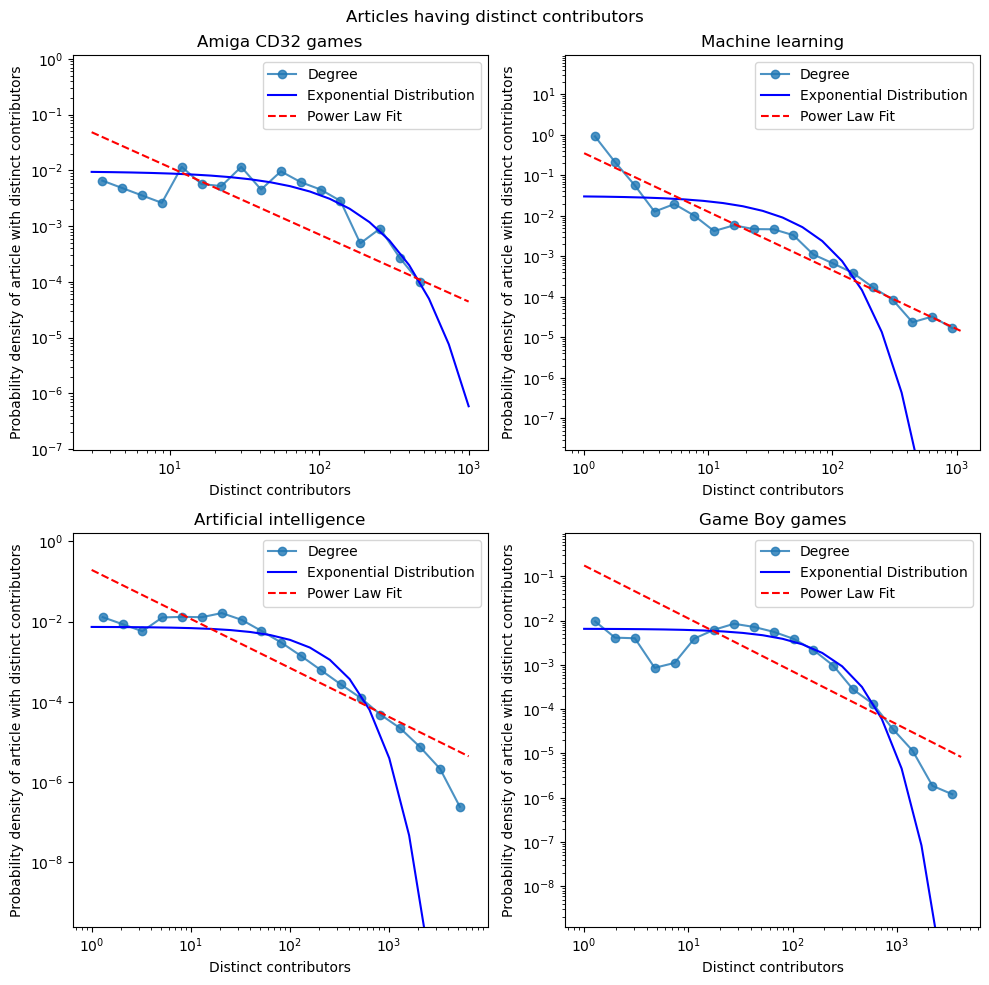

In [6]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
for i, name in enumerate(graph_names):
        unique_contributors = get_unique_contributors_list_from_graph_name(name)
        logarithmic_bins = np.logspace(np.log10(min(unique_contributors)), np.log10(max(unique_contributors)), num=20)
        hist_densitiy, bin_edges = np.histogram(unique_contributors, bins=logarithmic_bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Find the center of each bin
        #remove values with 0 probability
        bin_centers = bin_centers[hist_densitiy > 0]
        hist_densitiy = hist_densitiy[hist_densitiy > 0]
        axs[i//2, i%2].plot(bin_centers, hist_densitiy, '-o', label='Degree', alpha=0.8)
        
        # x,y = calculate_poisson_degree_distribution(unique_contributors, logarithmic_bins)
        # axs[i//2, i%2].plot(x, y, color='g', linestyle='-', label='Poisson Distribution')
        
        x,y = calculate_exponential_degree_distribution(unique_contributors, logarithmic_bins)
        axs[i//2, i%2].plot(x, y, color='b', linestyle='-', label='Exponential Distribution')
        
        # add the power law fit to the plot
        fit = powerlaw.Fit(unique_contributors, discrete=True, xmin=1)
        fit.power_law.plot_pdf(color='r', linestyle='--', label='Power Law Fit', ax=axs[i//2, i%2])
        
        axs[i//2, i%2].set_xscale('log')  # This was missing in original
        axs[i//2, i%2].set_yscale('log')
        axs[i//2, i%2].set_ylim([0.001*min(hist_densitiy), 100*max(hist_densitiy)])
        axs[i//2, i%2].legend()
        axs[i//2, i%2].set_title(f'{name}')
        axs[i//2, i%2].set_xlabel('Distinct contributors')
        axs[i//2, i%2].set_ylabel('Probability density of article with distinct contributors')

fig.suptitle('Articles having distinct contributors')

plt.tight_layout()
plt.show()
